 Goal is to predict UPDRS

# Importing Data & Libraries

In [3]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow_decision_forests


Note: you may need to restart the kernel to use updated packages.


In [71]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


In [6]:
#import data
proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
peptides= pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
clinical= pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
supplemental= pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")


# Viewing Data

In [7]:
#get shape
print(proteins.shape)
print(peptides.shape)
print(clinical.shape)

(232741, 5)
(981834, 6)
(2615, 8)


In [8]:
proteins.head()


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


NPX(Normalized Protein eXpression): value of concentration for all the proteins relevant to Parkinson. Just note proteins are made of peptides.

In [9]:
peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


Peptide Abundance: Abundance of each peptide in proteins relevant to parkinson. AKA: Concentration of peptides. NOT TO BE CONFUSED with peptide abundance.

In [10]:
clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


# Data Definitions

*  visit ID     is the ID code for the visit.
*  Visit_month  is the month of the visit, relative to the first visit by the patient.
*  Patient_id   is the specific ID code for the patient.
*  UniProt      is the UniProt ID code for the associated protein. Several peptides make a protein.
*  Peptide      is the sequence of amino acids included in the peptide.
*  NPX          is the normalized protein expression. The frequency of the protein's occurrence in the sample. 
*  updrs_[1-4]  is the patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.

* upd23b_clinical_state_on_medication  Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

# Plotting Data

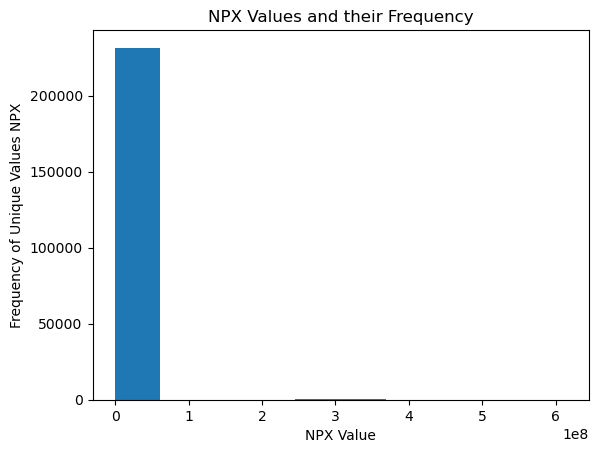

In [31]:
plt.hist(proteins["NPX"])
plt.xlabel("NPX Value") # what type of number appears
plt.ylabel("Frequency of Unique Values NPX")# how many times the number appears
plt.title("NPX Values and their Frequency")
plt.show()

Protein abundance has a skewed range.
Check out the unique values.


In [35]:
UniNPX =proteins["NPX"].unique()

print("max is", UniNPX.max())
print("min is" , UniNPX.min())
print( "mean is", UniNPX.mean())

max is 613851000.0
min is 84.6082
mean is 2856834.2224777536


This data has a wide range. Remebmer to scale your data later on!!!!!

Now lets view peptide abundance.

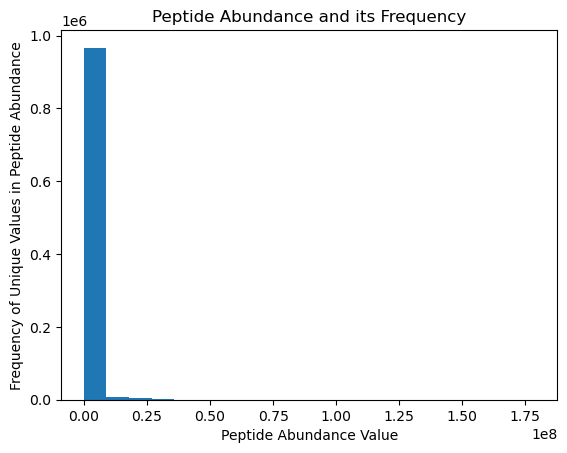

In [38]:
#percents of unique values of Peptide abundance

plt.hist(peptides["PeptideAbundance"], bins=20)
plt.xlabel("Peptide Abundance Value") # what type of number appears
plt.ylabel("Frequency of Unique Values in Peptide Abundance")# how many times the number appears
plt.title("Peptide Abundance and its Frequency")
plt.show()


Peptide abundance has a skewed range.
Check out the unique values.


In [44]:
pep_unique=pd.DataFrame(peptides["PeptideAbundance"].unique())
pep_unique.head()
print("Min is:", pep_unique.min())
print("Max is:", pep_unique.max())
print("Mean is:", pep_unique.mean())

Min is: 0    10.9985
dtype: float64
Max is: 0    178752000.0
dtype: float64
Mean is: 0    798078.241981
dtype: float64


Zoom In on The graph

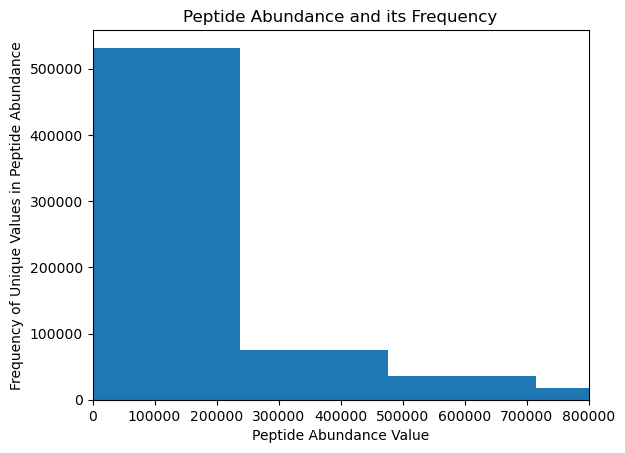

In [46]:
plt.hist(pep_unique, bins= 750)
plt.xlabel("Peptide Abundance Value") # what type of number appears
plt.ylabel("Frequency of Unique Values in Peptide Abundance")# how many times the number appears
plt.title("Peptide Abundance and its Frequency")
plt.xlim(-0, 800000)
plt.show()

This data has a wide range. Remebmer to scale your data later on!!!!!
But lets note that most peptides have a  concentration in the 100000s

In [60]:
#Lets see what standard scaler does|
pep_feature_2d = pep_feature.values.reshape(-1, 1)

# If 'pep_feature' is a NumPy array:
# pep_feature_2d = pep_feature.reshape(-1, 1)

# Create a StandardScaler instance
norm = StandardScaler()

# Fit the scaler to your 2D feature (compute mean and standard deviation)
scaler.fit(pep_feature_2d)

# Transform (scale) your feature using the computed mean and standard deviation
scaled_pep = scaler.transform(pep_feature_2d)



(array([9.75433e+05, 5.08900e+03, 3.26000e+02, 4.85000e+02, 3.69000e+02,
        9.70000e+01, 2.70000e+01, 6.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-0.19031428,  5.10135704, 10.39302836, 15.68469968, 20.976371  ,
        26.26804232, 31.55971364, 36.85138496, 42.14305628, 47.4347276 ,
        52.72639892]),
 <BarContainer object of 10 artists>)

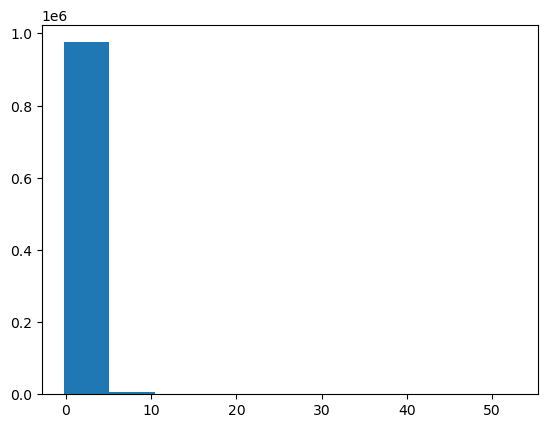

In [55]:
plt.hist(scaled_pep)

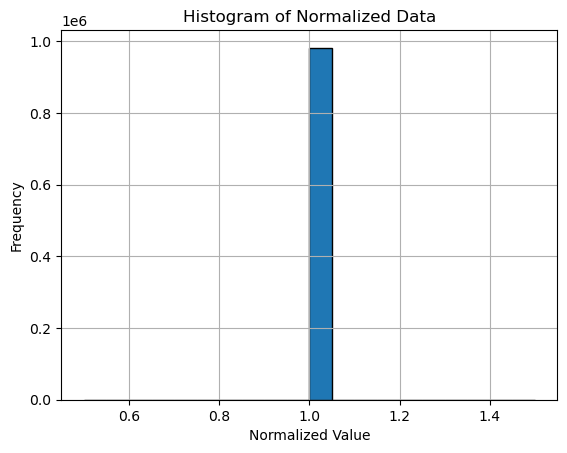

In [61]:
#lets see what normalizer does
normalizer = Normalizer()
normalized_pep = normalizer.fit_transform(pep_feature_2d)
# Create a histogram
plt.hist(normalized_pep, bins=20, edgecolor='k')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized Data')
plt.grid(True)

# Show the histogram
plt.show()

Not much change. Lets take a look at Min Max Scaler. Normalizer wouldnt be the best function anyway, Becuase features are represented by columns and not rows.


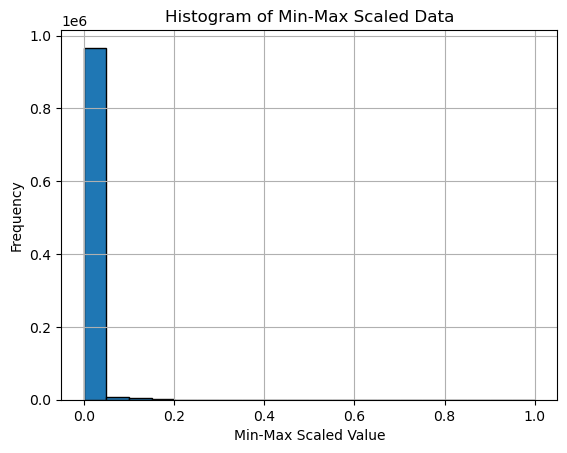

In [63]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform your normalized data
minmax_scaled_pep = scaler.fit_transform(pep_feature_2d)

# Create a histogram
plt.hist(minmax_scaled_pep, bins=20, edgecolor='k')
plt.xlabel('Min-Max Scaled Value')
plt.ylabel('Frequency')
plt.title('Histogram of Min-Max Scaled Data')
plt.grid(True)

# Show the histogram
plt.show()



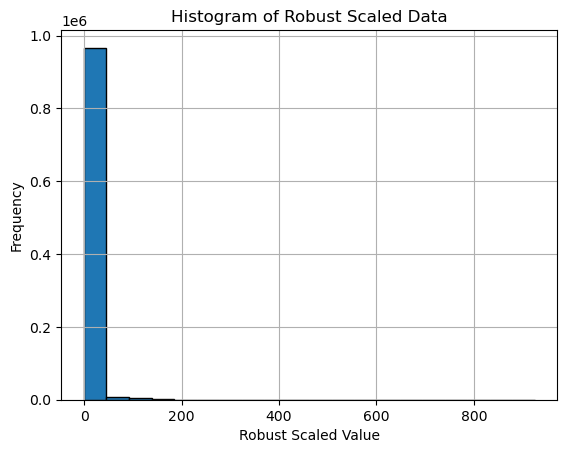

In [72]:
# Create a RobustScaler instance
scaler = RobustScaler()

# Fit and transform your normalized data
robust_scaled_pep = scaler.fit_transform(pep_feature_2d)

# Create a histogram
plt.hist(robust_scaled_pep, bins=20, edgecolor='k')
plt.xlabel('Robust Scaled Value')
plt.ylabel('Frequency')
plt.title('Histogram of Robust Scaled Data')
plt.grid(True)

# Show the histogram
plt.show()

Viewing UPRDS 

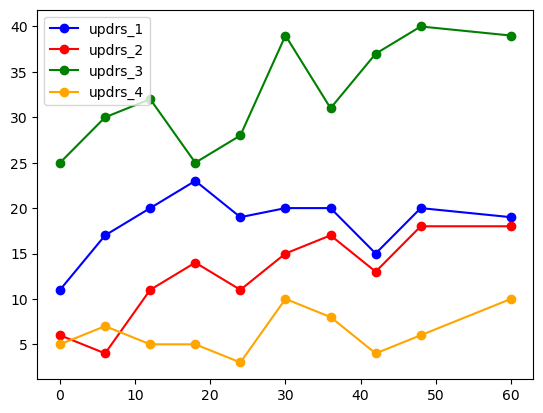

In [14]:
# Fetch data for patient with id 1517
plot_df = clinical[clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

Preparing a correlation heat map

In [81]:
df_heat= pd.DataFrame({"Visit_Month": proteins["visit_month"], "updrs-1":clinical["updrs_1"],"updrs-2":clinical["updrs_2"],"updrs-3":clinical["updrs_3"],"updrs-4":clinical["updrs_4"],"Protein Abund.":proteins["NPX"],"Peptide Abund.": peptides["PeptideAbundance"]})

In [84]:
corr= df_heat.corr()

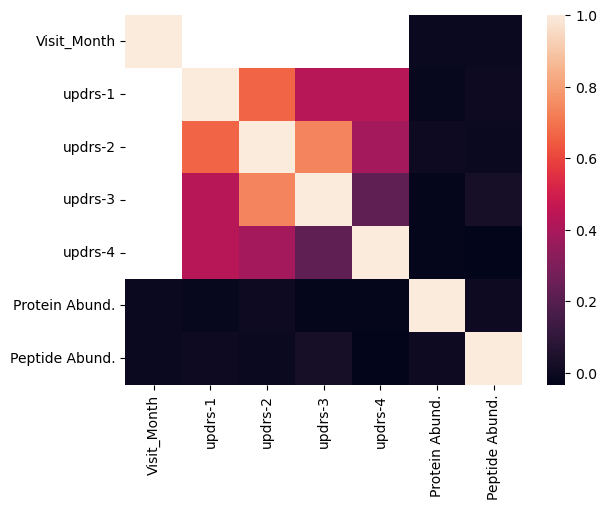

In [85]:
sns.heatmap(corr)
plt.show()

Cant Conclude much; However, as expected there seems to be a correlation between the values of interest including- NPX,Peptide abundance, and UPDRs1-4.


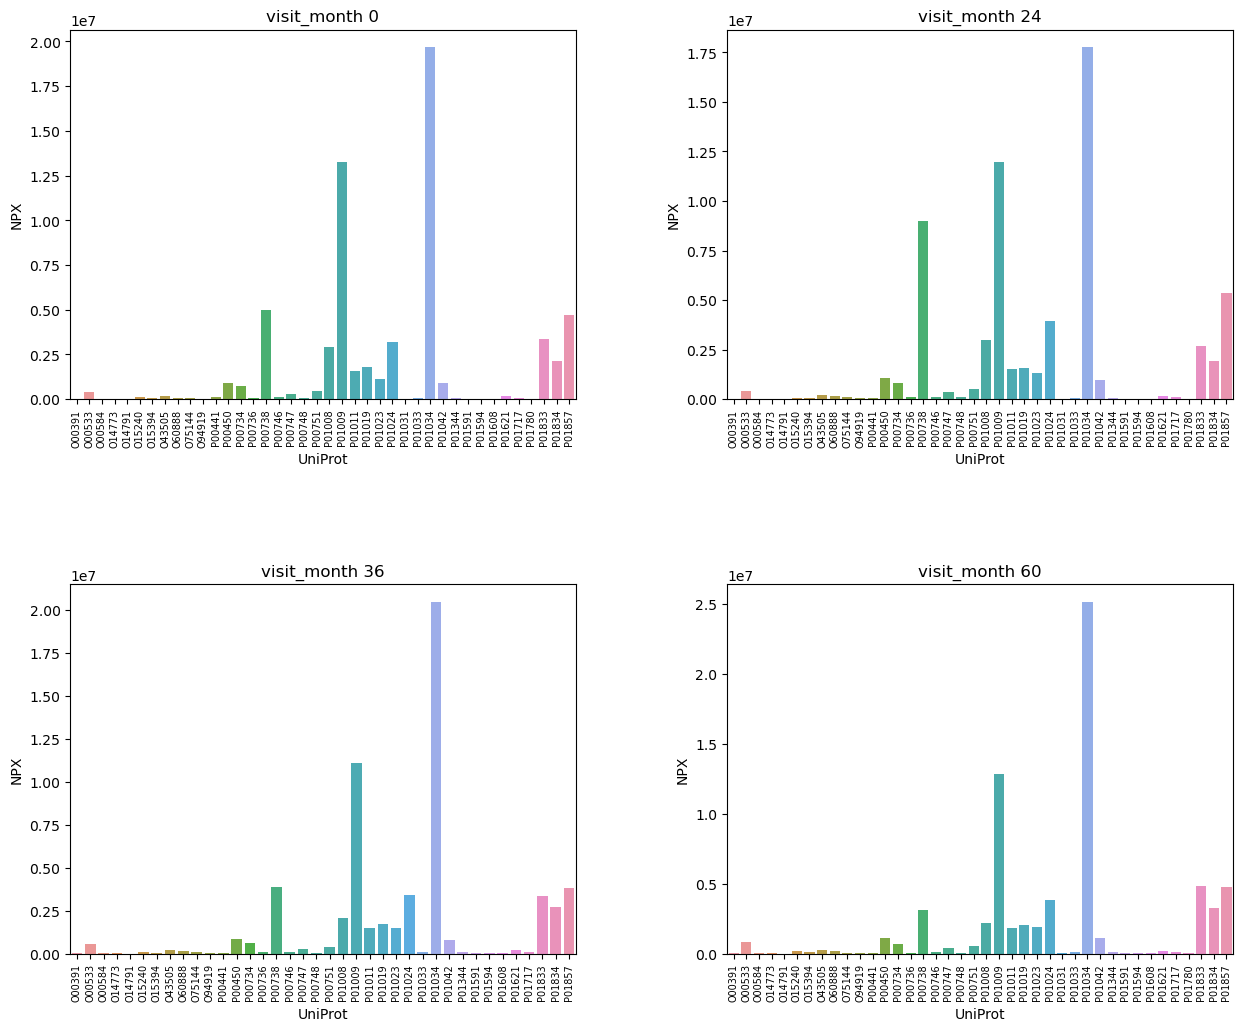

In [15]:
pro_plot_df =proteins[proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

# Preparing Data

#proteins
1. group by visit ID
2. group by protein ID
3. replace NPX in a group with NPX mean

#peptides
1. group by visit ID
2. group by peptide ids
3. replace peptide abundance values with mean of the peptideabundance values of all rows in that group

Obtaining labels for UPDRS1,2,3,4
  

Need to pivot data to get Visit ID as Index, and protein ID as columns.
Same for peptides.

In [16]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df
    

In [17]:
pro_pep_df = prepare_dataset(proteins,peptides)

In [18]:
pro_pep_df.shape

(1113, 1196)

In [19]:
pro_pep_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [20]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


Selecting  Models to Test:

* Random Forests
* GBM

# Preparing Labels, Cleaning Data, & Modeling With Random Forest

In [21]:
# Creating Features List
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")
print(FEATURES)

['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240', 'O15394', 'O43505', 'O60888', 'O75144', 'O75326', 'O94919', 'P00441', 'P00450', 'P00734', 'P00736', 'P00738', 'P00746', 'P00747', 'P00748', 'P00751', 'P01008', 'P01009', 'P01011', 'P01019', 'P01023', 'P01024', 'P01031', 'P01033', 'P01034', 'P01042', 'P01344', 'P01591', 'P01594', 'P01608', 'P01621', 'P01717', 'P01780', 'P01833', 'P01834', 'P01857', 'P01859', 'P01860', 'P01861', 'P01876', 'P01877', 'P02452', 'P02647', 'P02649', 'P02652', 'P02655', 'P02656', 'P02671', 'P02675', 'P02679', 'P02747', 'P02748', 'P02749', 'P02750', 'P02751', 'P02753', 'P02760', 'P02763', 'P02765', 'P02766', 'P02768', 'P02774', 'P02787', 'P02790', 'P02792', 'P04004', 'P04075', 'P04156', 'P04180', 'P04196', 'P04207', 'P04211', 'P04216', 'P04217', 'P04275', 'P04406', 'P04433', 'P05060', 'P05067', 'P05090', 'P05155', 'P05156', 'P05408', 'P05452', 'P05546', 'P06310', 'P06396', 'P06454', 'P06681', 'P06727', 'P07195', 'P07225', 'P07333', 'P07339',

Initiating Empty list

In [22]:
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

Smape Function: to check data

In [23]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

Create a loop to :

Part1
1. Define a Function to Split Data 
2. merge
3. drop null values
4. Scale data

Part 2

4. split and train the data set
5. Convert the dataset pandas-> tensorflow for faster processing

In [24]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [28]:
 scaler = StandardScaler()

# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(clinical[['visit_id', 'patient_id', 'visit_month', label]], on=['visit_id'], how='left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)
    
    # Scale the features in the Pandas DataFrame
    train_scaled = scaler.fit_transform(dataset_df[feature_list].values)
    
    # Convert the scaled DataFrame back to a Pandas DataFrame
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_list)
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(train_scaled_df)
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # Convert the Pandas DataFrame to TensorFlow datasets
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Create and train the Random Forest model
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])
    rf.fit(x=train_ds)
    
    # Store the trained model
    model_dict[label] = rf
    
    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds, return_dict=True)
    mse_dict[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    smape_dict[label] = smape(valid_df[label].values.tolist(), preds.flatten())

837 examples in training, 231 examples in testing.


[INFO 23-09-20 23:57:50.2062 UTC kernel.cc:1242] Loading model from path /tmp/tmpo13l9rz0/model/ with prefix 75447ff2f4ae4dfc
[INFO 23-09-20 23:57:50.5099 UTC decision_forest.cc:660] Model loaded with 300 root(s), 69618 node(s), and 1196 input feature(s).
[INFO 23-09-20 23:57:50.5101 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-20 23:57:50.5111 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 3s 3s/step
839 examples in training, 229 examples in testing.


[INFO 23-09-20 23:59:23.3703 UTC kernel.cc:1242] Loading model from path /tmp/tmp8woqeguo/model/ with prefix fcb900528b084539
[INFO 23-09-20 23:59:23.6625 UTC decision_forest.cc:660] Model loaded with 300 root(s), 65380 node(s), and 1196 input feature(s).
[INFO 23-09-20 23:59:23.6627 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-20 23:59:23.6637 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step
849 examples in training, 209 examples in testing.


[INFO 23-09-21 00:01:13.3400 UTC kernel.cc:1242] Loading model from path /tmp/tmpm1nm5m7u/model/ with prefix f56ce1a81def42d7
[INFO 23-09-21 00:01:13.6624 UTC decision_forest.cc:660] Model loaded with 300 root(s), 73234 node(s), and 1196 input feature(s).
[INFO 23-09-21 00:01:13.6626 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-21 00:01:13.6637 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step
461 examples in training, 108 examples in testing.


[INFO 23-09-21 00:02:19.7152 UTC kernel.cc:1242] Loading model from path /tmp/tmput97cwei/model/ with prefix 01def28e9eef4312
[INFO 23-09-21 00:02:19.8237 UTC decision_forest.cc:660] Model loaded with 300 root(s), 24492 node(s), and 1194 input feature(s).
[INFO 23-09-21 00:02:19.8240 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-21 00:02:19.8249 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step


In [ ]:
#Now lets try with robust scaler model2


# 

# Verifying Model 1

MSE

In [36]:
for name, value in mse_dict.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict.values())/4)

label updrs_1: mse 0.7529
label updrs_2: mse 0.7702
label updrs_3: mse 0.9462
label updrs_4: mse 1.0851

Average mse 0.8885956704616547


sMAPE

In [37]:
for name, value in smape_dict.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict.values())/4)

label updrs_1: sMAPE 142.4297
label updrs_2: sMAPE 134.5839
label updrs_3: sMAPE 142.3095
label updrs_4: sMAPE 150.9344

Average sMAPE 142.56436742952815


# Model 2

Used a robust scale instead of a standard scaler!Because my data is not originally normaly distributed.

In [66]:
#empty lists 2
model_dict2 = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict2 = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict2 = {}

In [67]:
scaler = RobustScaler()

# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(clinical[['visit_id', 'patient_id', 'visit_month', label]], on=['visit_id'], how='left')
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)
    
    # Scale the features in the Pandas DataFrame using RobustScaler
    train_scaled = scaler.fit_transform(dataset_df[feature_list].values)
    
    # Convert the scaled DataFrame back to a Pandas DataFrame
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_list)
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(train_scaled_df)
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # Convert the Pandas DataFrame to TensorFlow datasets
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Create and train the Random Forest model
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])
    rf.fit(x=train_ds)
    
    # Store the trained model
    model_dict2[label] = rf
    
    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds, return_dict=True)
    mse_dict2[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    smape_dict2[label] = smape(valid_df[label].values.tolist(), preds.flatten())

857 examples in training, 211 examples in testing.


[INFO 23-09-21 01:49:42.5201 UTC kernel.cc:1242] Loading model from path /tmp/tmpp72zqa0t/model/ with prefix e5f2c78adf2d4218
[INFO 23-09-21 01:49:42.8861 UTC decision_forest.cc:660] Model loaded with 300 root(s), 70218 node(s), and 1196 input feature(s).
[INFO 23-09-21 01:49:42.8864 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-21 01:49:42.8875 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step
865 examples in training, 203 examples in testing.


[INFO 23-09-21 01:51:14.2167 UTC kernel.cc:1242] Loading model from path /tmp/tmpexh8p3a1/model/ with prefix cdbe30850b2f4562
[INFO 23-09-21 01:51:14.5086 UTC decision_forest.cc:660] Model loaded with 300 root(s), 67722 node(s), and 1196 input feature(s).
[INFO 23-09-21 01:51:14.5088 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-21 01:51:14.5100 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step
825 examples in training, 233 examples in testing.


[INFO 23-09-21 01:52:41.2326 UTC kernel.cc:1242] Loading model from path /tmp/tmphsdwxsvo/model/ with prefix a5de9774ed484eeb
[INFO 23-09-21 01:52:41.5477 UTC decision_forest.cc:660] Model loaded with 300 root(s), 71550 node(s), and 1196 input feature(s).
[INFO 23-09-21 01:52:41.5479 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-21 01:52:41.5491 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step
456 examples in training, 113 examples in testing.


[INFO 23-09-21 01:53:45.6467 UTC kernel.cc:1242] Loading model from path /tmp/tmpkc604e3x/model/ with prefix 0201dc1979b34528
[INFO 23-09-21 01:53:45.8216 UTC decision_forest.cc:660] Model loaded with 300 root(s), 25112 node(s), and 1196 input feature(s).
[INFO 23-09-21 01:53:45.8221 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-21 01:53:45.8235 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 3s 3s/step


In [24]:
dataset_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id,visit_month,updrs_4
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30,10053.0,0.0,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80,10053.0,12.0,0.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70,10053.0,18.0,0.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98,10138.0,12.0,0.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09,10138.0,24.0,10.0


# Verifying Model2:
sMAPE &MSE


MSE model2



In [68]:
for name, value in mse_dict2.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict2.values())/4)

label updrs_1: mse 0.4437
label updrs_2: mse 0.3710
label updrs_3: mse 0.2635
label updrs_4: mse 1.0400

Average mse 0.5295524522662163


sMAPE model2

In [69]:
for name, value in smape_dict2.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict2.values())/4)

label updrs_1: sMAPE 137.5798
label updrs_2: sMAPE 138.6005
label updrs_3: sMAPE 140.5649
label updrs_4: sMAPE 156.5564

Average sMAPE 143.32541846836622


# Conclusion & Wrap-up

Model2's MSE scores performned better than model 3 by scoring a lower average of 0.529 vs 0.88
the sMAPE score barely changed. It increased from 142.9 to 143.3